# Google Cloud CMIP6 Public Data: Basic Python Example

This notebooks shows how to query the catalog and load the data using python

In [4]:
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
plt.rcParams['figure.figsize'] = 12, 6

## Browse Catalog

The data catatalog is stored as a CSV file. Here we read it with Pandas.

In [22]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


The columns of the dataframe correspond to the CMI6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q).

Here we filter the data to find monthly surface air temperature for historical experiments.

In [23]:
df_ta = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
973,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1766,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
22185,CMIP,IPSL,IPSL-CM6A-LR,historical,r8i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
22298,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
...,...,...,...,...,...,...,...,...,...,...,...
522952,CMIP,MRI,MRI-ESM2-0,historical,r7i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210813
523274,CMIP,MRI,MRI-ESM2-0,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210907
523712,CMIP,CMCC,CMCC-CM2-SR5,historical,r3i1p2f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211108
523721,CMIP,CMCC,CMCC-CM2-SR5,historical,r2i1p2f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211109


Now we do further filtering to find just the models from NCAR.

In [24]:
df_ta_ncar = df_ta.query('institution_id == "NCAR"')
df_ta_ncar

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
56049,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56143,CMIP,NCAR,CESM2-WACCM,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56326,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61655,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61862,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
62691,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
63131,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
63266,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
64615,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311


## Load Data

Now we will load a single store using gcsfs, zarr, and xarray.

In [10]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_ncar.loc[59875].zstore

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset> Size: 438MB
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lat_bnds   (lat, nbnd) float32 2kB ...
    lon_bnds   (lon, nbnd) float32 2kB ...
    time_bnds  (time, nbnd) object 32kB ...
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 438MB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                15
    ...                     ...
    table_id:               Amon
    tracking_id:            hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu

Plot a map from a specific date.

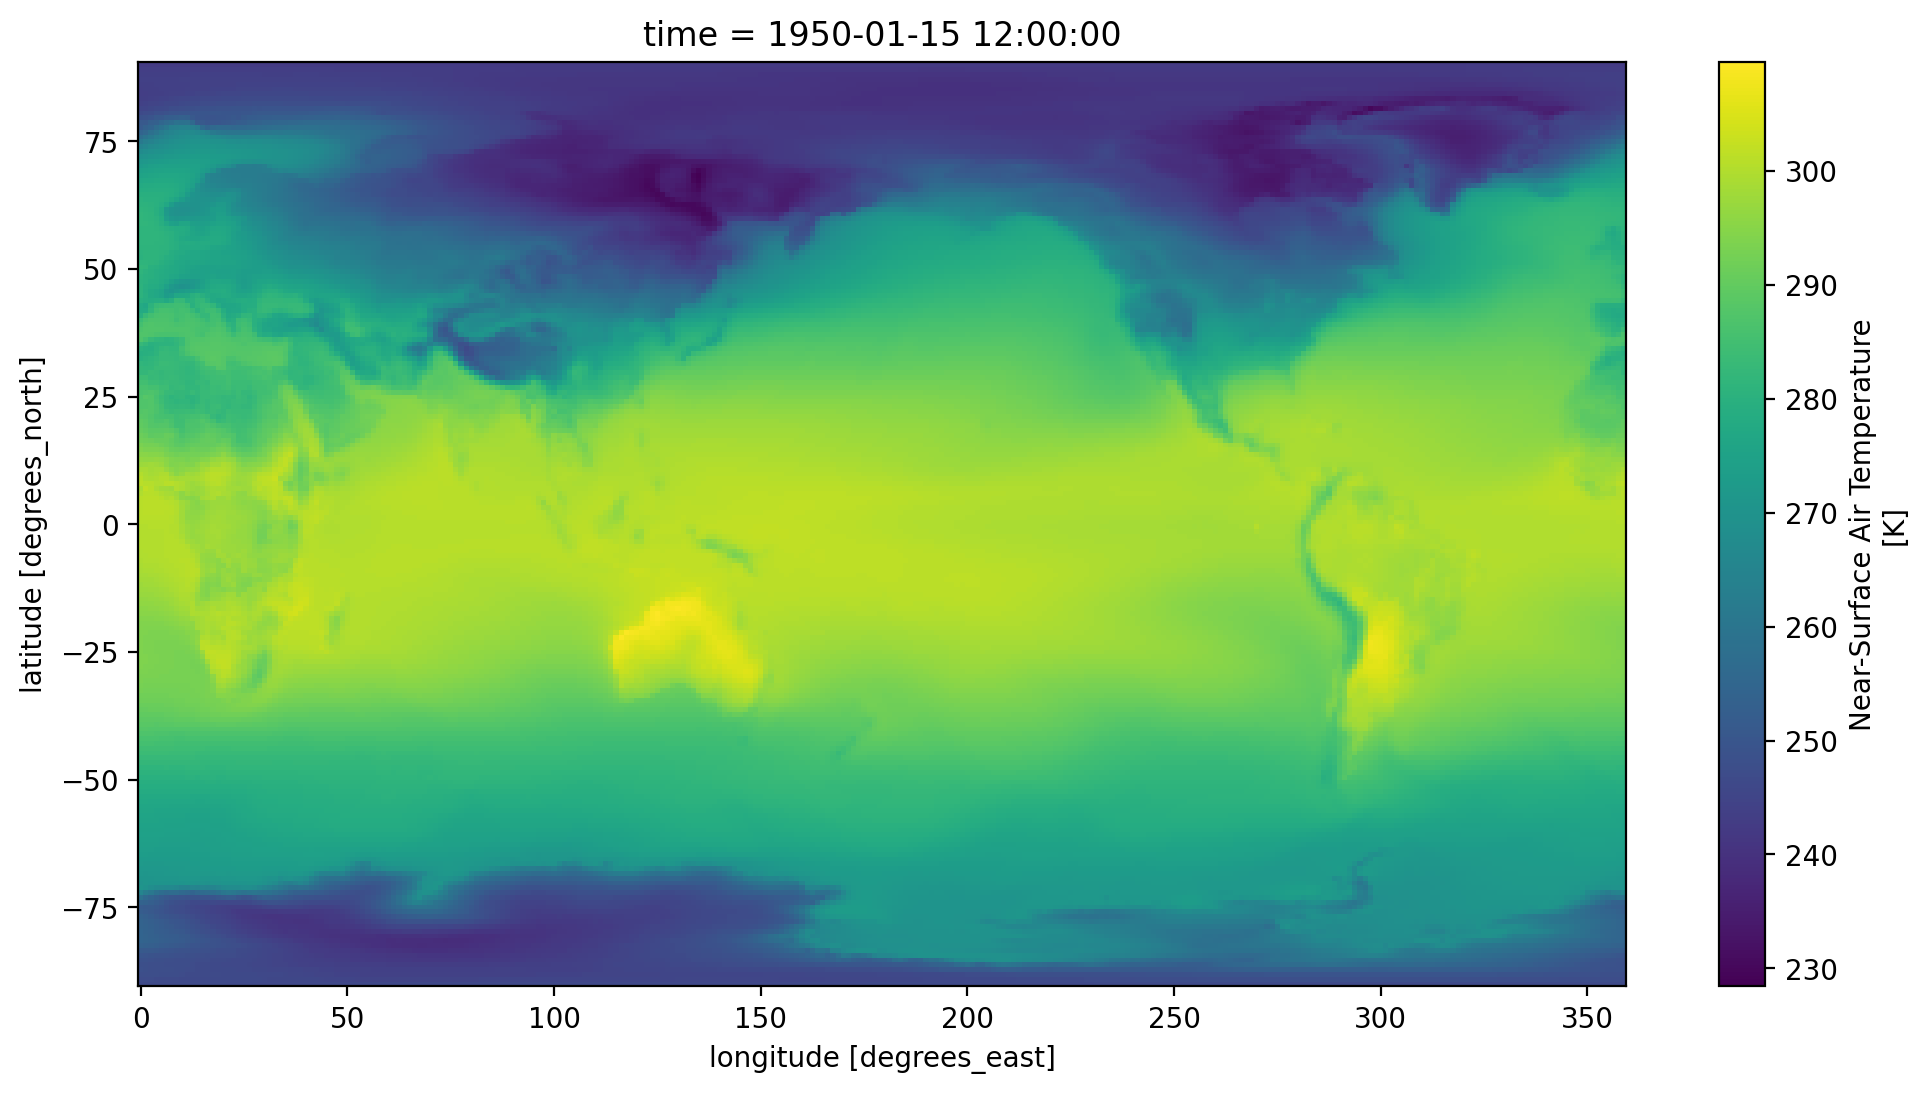

In [11]:
ds.tas.sel(time='1950-01').squeeze().plot()

Create a timeseries of global-average surface air temperature. For this we need the area weighting factor for each gridpoint.

In [12]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset> Size: 229kB
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lat_bnds   (lat, nbnd) float32 2kB ...
    lon_bnds   (lon, nbnd) float32 2kB ...
Dimensions without coordinates: nbnd
Data variables:
    areacella  (lat, lon) float32 221kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   711385.0
    branch_time_in_parent:  0.0
    case_id:                38
    ...                     ...
    table_id:               fx
    tracking_id:            hdl:21.14100/23fa9dc3-4f8f-4943-b99b-58eb804c06f0
    variable_id:            areacella
    variant_info:           f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001 
\n
\...
    variant_label:          r1i1p1f1
    status:                 2019-11-04;created;by nhn2@columbia.edu

In [13]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)> Size: 8kB
array([285.2367 , 285.49353, 286.10147, ..., 288.3483 , 287.31396,
       286.56613], dtype=float32)
Coordinates:
  * time     (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [14]:
ta_timeseries.load()

<xarray.DataArray (time: 1980)> Size: 8kB
array([285.2367 , 285.49353, 286.10147, ..., 288.3483 , 287.31396,
       286.56613], dtype=float32)
Coordinates:
  * time     (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

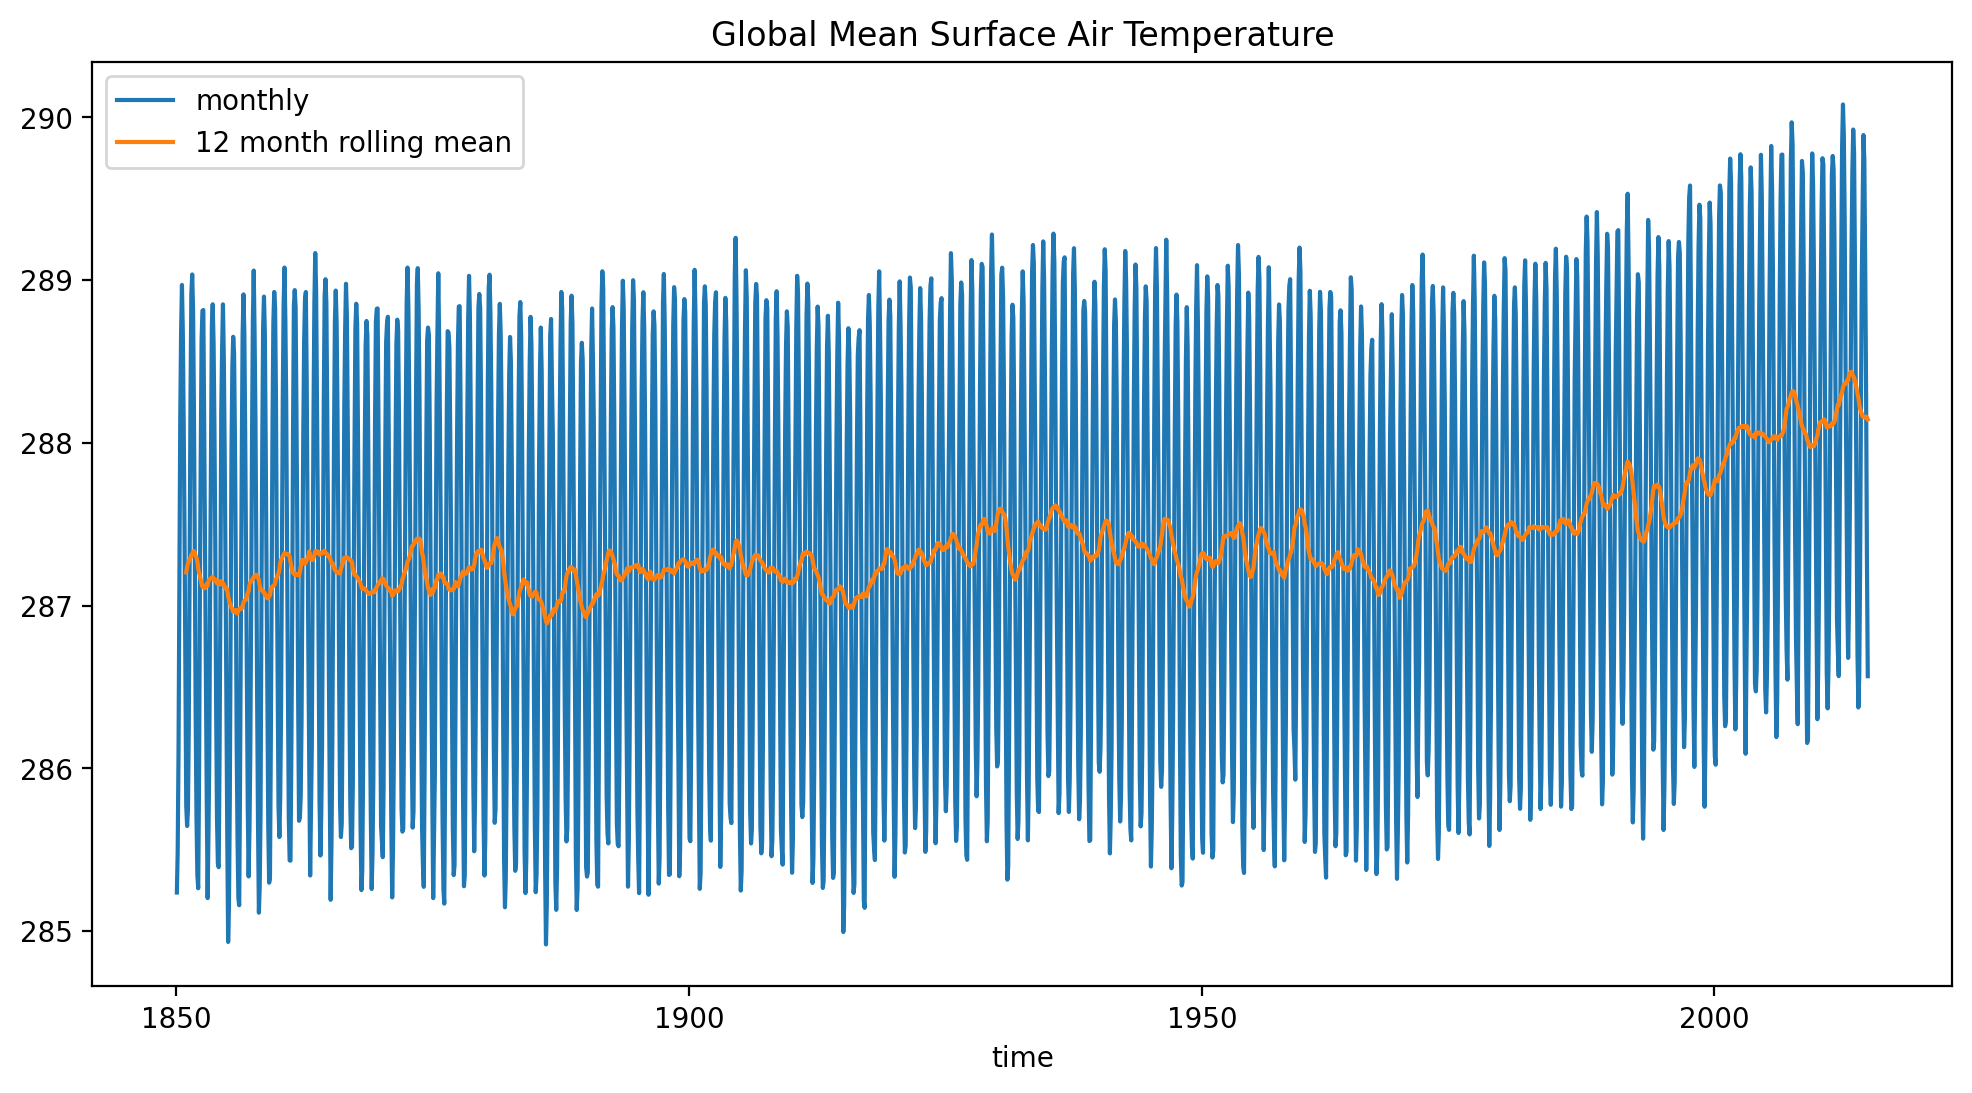

In [15]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

Or, we can select e.g. San Diego

In [16]:
sd_time_series = ds.tas.sel(lon=360-117.1611, lat=32.7157, method='nearest')

Text(0.5, 1.0, 'San Diego Surface Air Temperature')

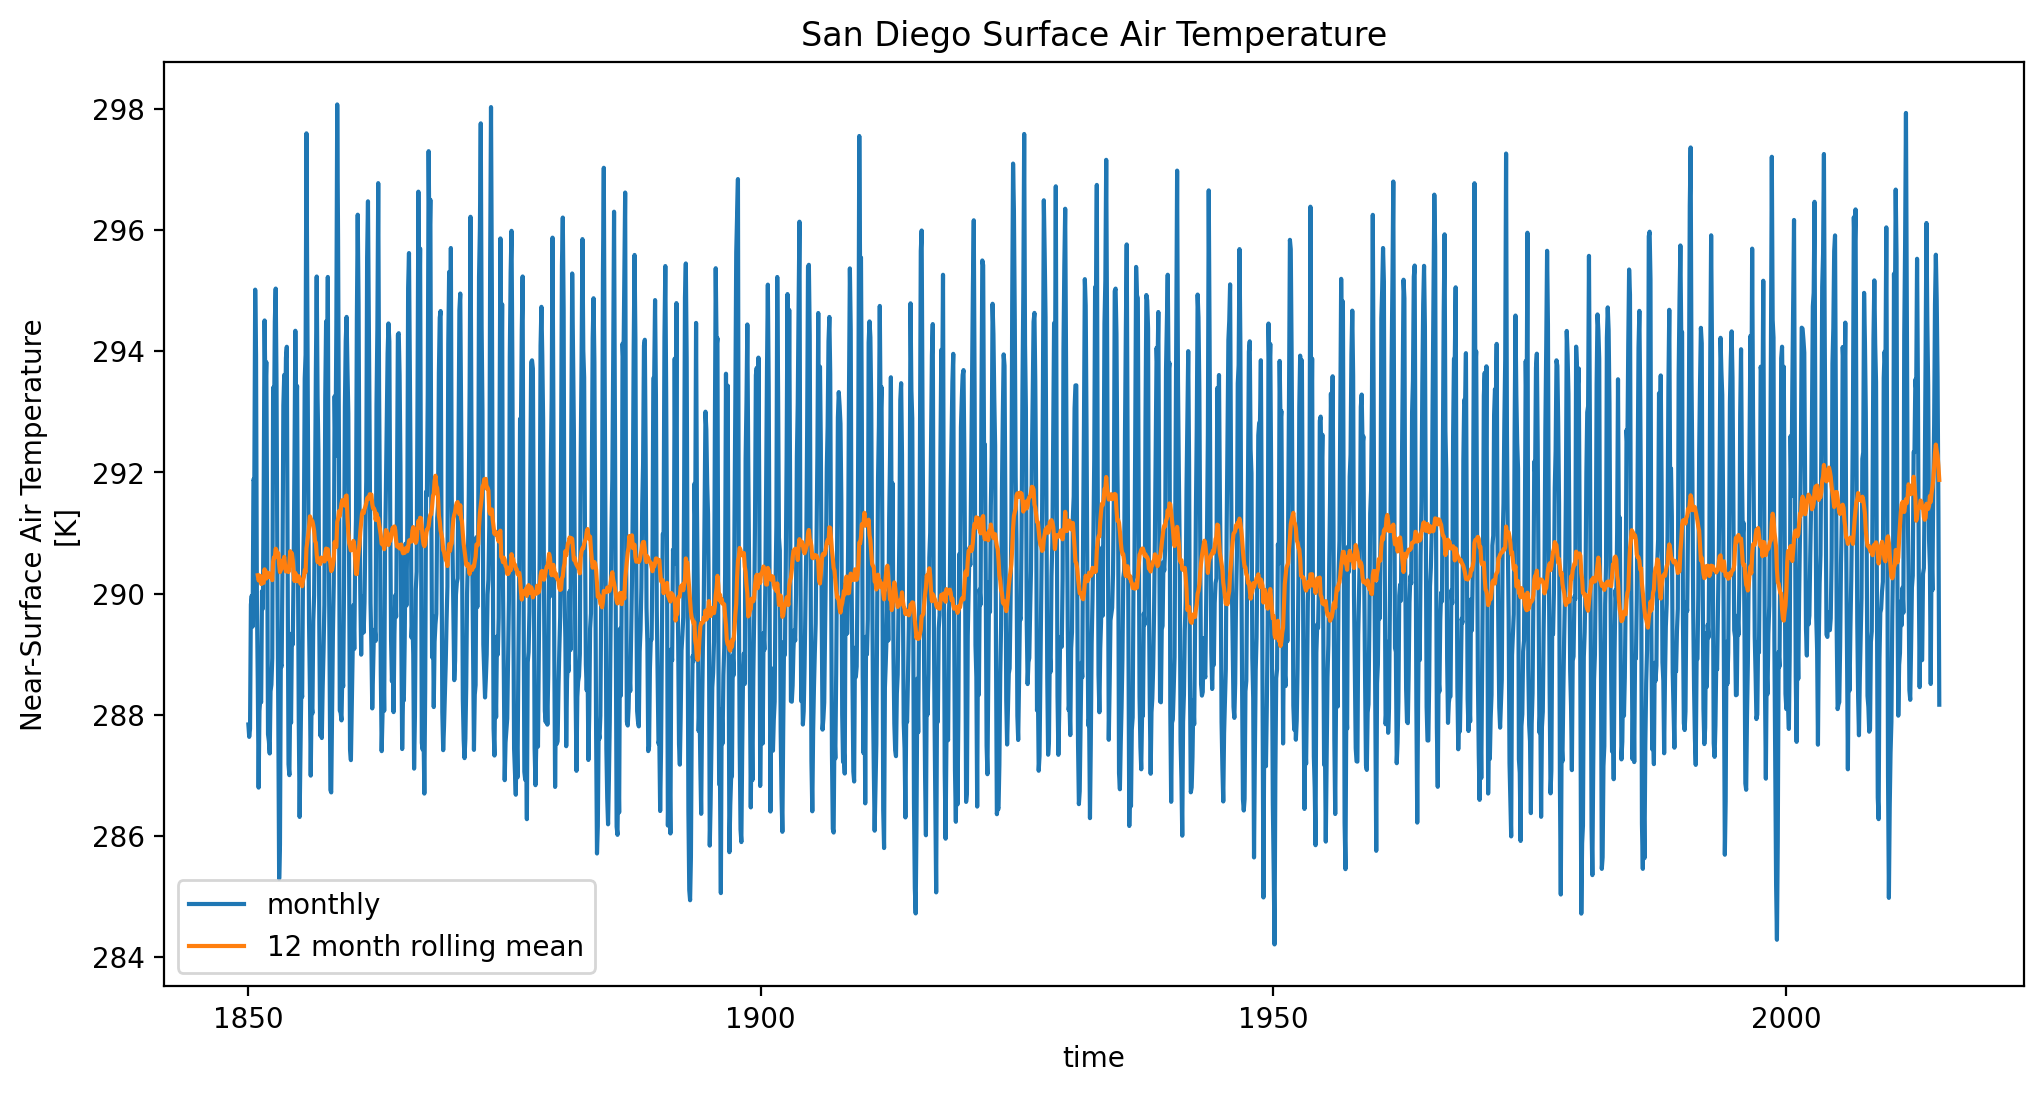

In [17]:
sd_time_series.plot(label='monthly')
sd_time_series.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('San Diego Surface Air Temperature')

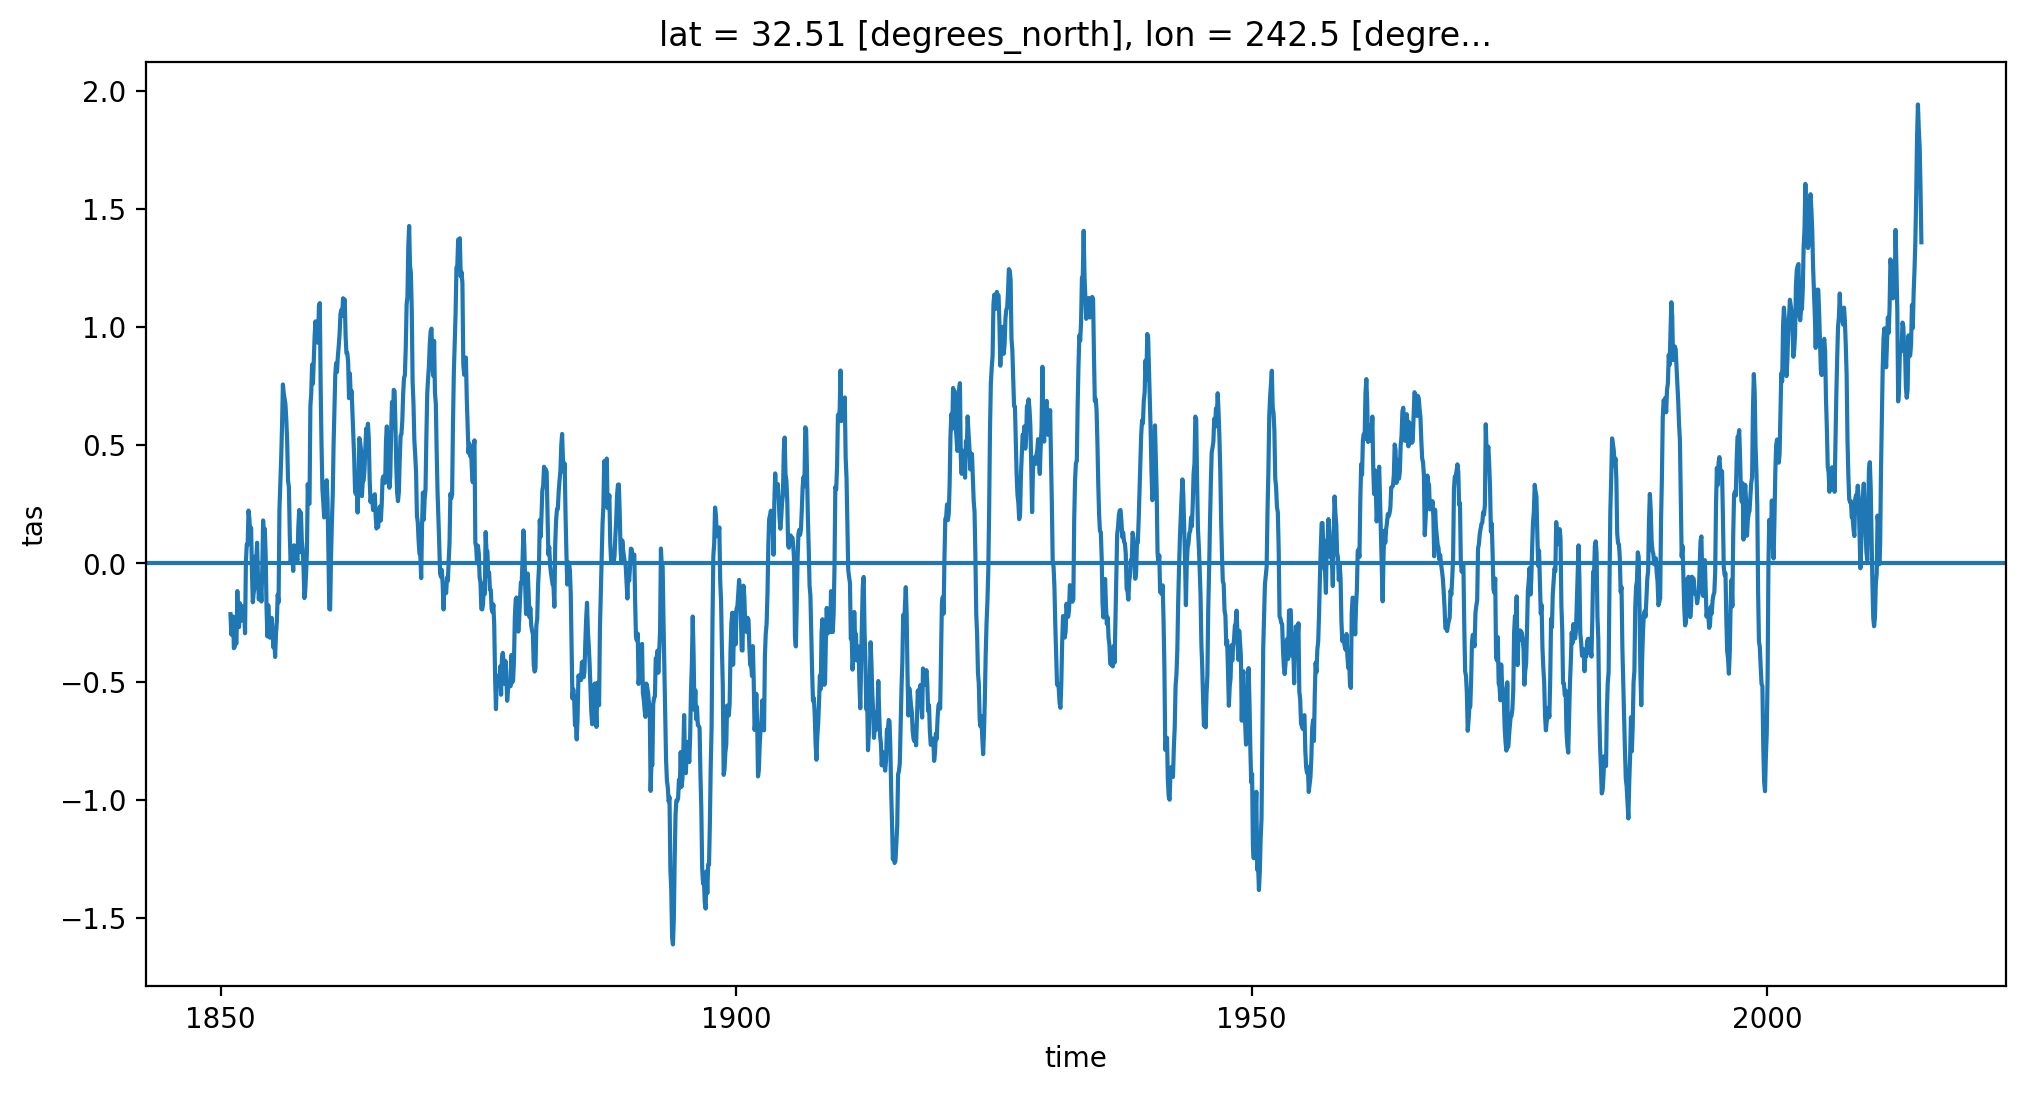

In [18]:
(sd_time_series.rolling(time=12).mean()-sd_time_series.sel(time=slice("1850","1900")).mean()).plot(label='12 month rolling mean')
plt.axhline(0.)

In [25]:
df_ta_2 = df.query("activity_id=='CMIP' & table_id == 'Amon' & experiment_id == 'historical'")
df_ta_2

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
537,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,ccb,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180301
971,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,tasmin,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
972,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
973,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
974,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,ta,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
...,...,...,...,...,...,...,...,...,...,...,...
523769,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523770,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523771,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
523772,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


In [26]:
df_ta_ncar_2 = df_ta_2.query('institution_id == "NCAR"')
df_ta_ncar_2


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
55925,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
55933,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,clivi,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
55943,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,hfss,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
55944,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
55945,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,evspsbl,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
...,...,...,...,...,...,...,...,...,...,...,...
422522,CMIP,NCAR,CESM2-FV2,historical,r2i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historica...,NaN,20200226
422523,CMIP,NCAR,CESM2-FV2,historical,r2i1p1f1,Amon,rsus,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historica...,NaN,20200226
422524,CMIP,NCAR,CESM2-FV2,historical,r2i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historica...,NaN,20200226
422525,CMIP,NCAR,CESM2-FV2,historical,r2i1p1f1,Amon,cli,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historica...,NaN,20200226


In [27]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_2.loc[59875].zstore

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset> Size: 438MB
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lat_bnds   (lat, nbnd) float32 2kB ...
    lon_bnds   (lon, nbnd) float32 2kB ...
    time_bnds  (time, nbnd) object 32kB ...
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 438MB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                15
    ...                     ...
    table_id:               Amon
    tracking_id:            hdl:21.14100/d9a7225a-49c3-4470-b7ab-a8180926f839
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [28]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset> Size: 229kB
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lat_bnds   (lat, nbnd) float32 2kB ...
    lon_bnds   (lon, nbnd) float32 2kB ...
Dimensions without coordinates: nbnd
Data variables:
    areacella  (lat, lon) float32 221kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   711385.0
    branch_time_in_parent:  0.0
    case_id:                38
    ...                     ...
    table_id:               fx
    tracking_id:            hdl:21.14100/23fa9dc3-4f8f-4943-b99b-58eb804c06f0
    variable_id:            areacella
    variant_info:           f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001 
\n
\...
    variant_label:          r1i1p1f1
    status:                 2019-11-04;created;by nhn2@columbia.edu

In [29]:
tas = ds['tas'] - 273.15 #deg celsius
tas_2010 = tas.sel(time=tas.time.dt.year == 2010)


In [30]:
w = np.cos(np.deg2rad(tas.lat))  
tas_zonal = tas_2010.weighted(w).mean(dim='lon')
df = tas_zonal.groupby('time.month').mean(dim='time').to_dataframe().reset_index()
df.to_csv('tas_vs_lat_2010.csv', index=False)